In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import ResNet50V2
from keras.datasets import cifar100
from keras import Sequential
from keras import Input
from keras.layers import UpSampling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import RandomFlip
from keras.layers import RandomTranslation
from keras.layers import RandomRotation
from keras.layers import RandomBrightness
from keras.layers import RandomContrast
from keras.layers import RandomZoom
from keras_cv.layers import RandomShear
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model
import re
import os
import datetime

Using TensorFlow backend


In [2]:
n_epoch = 1000 # Il y a le early stopping
batch_size = 400

In [3]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = np.float64(X_train)/255
X_test = np.float64(X_test)/255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = 100

In [4]:
resnet = ResNet50V2(include_top=False, weights='imagenet', pooling="avg")

for layer in resnet.layers[:]:
  if (re.match("^.*(_3_conv|_bn)$", layer.name)):
    layer.trainable = True
  else:
    layer.trainable = False

resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                         

In [5]:
model = Sequential([
    UpSampling2D(size=(7, 7)),
    RandomFlip("horizontal"),
    RandomTranslation(0.2,0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomShear(0.2),
    RandomBrightness(0.2,value_range=(0,1)),
    RandomContrast(0.2),
    resnet,
    Dense(256, activation="sigmoid"),
    Dropout(0.25),
    Dense(num_classes, activation="softmax")])

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_1 = model.fit(X_train, y_train, epochs=n_epoch, batch_size=batch_size, validation_split = 0.1,callbacks = early_stopping_callback)
model.save("/root/modele.keras")

Epoch 1/1000
113/113 [==============================] - 94s 506ms/step - loss: 2.7238 - accuracy: 0.3537 - val_loss: 2.0687 - val_accuracy: 0.4764
Epoch 2/1000
113/113 [==============================] - 46s 404ms/step - loss: 1.6514 - accuracy: 0.5608 - val_loss: 1.6507 - val_accuracy: 0.5552
Epoch 3/1000
113/113 [==============================] - 46s 404ms/step - loss: 1.4014 - accuracy: 0.6188 - val_loss: 1.3072 - val_accuracy: 0.6422
Epoch 4/1000
113/113 [==============================] - 46s 404ms/step - loss: 1.2600 - accuracy: 0.6526 - val_loss: 1.0962 - val_accuracy: 0.6870
Epoch 5/1000
113/113 [==============================] - 46s 404ms/step - loss: 1.1598 - accuracy: 0.6762 - val_loss: 1.0449 - val_accuracy: 0.6956
Epoch 6/1000
113/113 [==============================] - 46s 405ms/step - loss: 1.0806 - accuracy: 0.6964 - val_loss: 1.0397 - val_accuracy: 0.7056
Epoch 7/1000
113/113 [==============================] - 46s 403ms/step - loss: 1.0245 - accuracy: 0.7092 - val_loss: 1

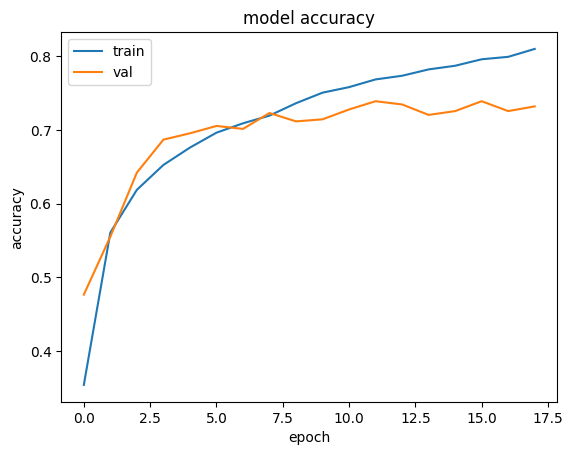

In [7]:
from matplotlib import pyplot as plt
plt.plot(history_1.history['accuracy'][:21])
plt.plot(history_1.history['val_accuracy'][:21])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 7s 21ms/step - loss: 0.8875 - accuracy: 0.7457


[0.8874627947807312, 0.7457000017166138]